<a href="https://colab.research.google.com/github/arnav39/d2el-en/blob/main/8_5_Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib_inline
!pip install --upgrade d2l==1.0.0a0

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
torch.is_grad_enabled()

True

In [7]:
a = torch.randn(1, 28, 28)

assert len(a.shape) in (2, 4)

AssertionError: ignored

In [8]:
a = torch.arange(16.).reshape(8, 2)
print(a)

tensor([[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.],
        [ 8.,  9.],
        [10., 11.],
        [12., 13.],
        [14., 15.]])


In [10]:
a_m = a.mean(dim=0)
a_hat = a - a_m
print(a_hat)

tensor([[-7., -7.],
        [-5., -5.],
        [-3., -3.],
        [-1., -1.],
        [ 1.,  1.],
        [ 3.,  3.],
        [ 5.,  5.],
        [ 7.,  7.]])


In [12]:
print(a_m.shape)
print(a_m)

torch.Size([2])
tensor([7., 8.])


In [14]:
torch.mean??

In [15]:
b = torch.arange(96.).reshape(2, 3, 4, 4)
print(b)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]],

         [[32., 33., 34., 35.],
          [36., 37., 38., 39.],
          [40., 41., 42., 43.],
          [44., 45., 46., 47.]]],


        [[[48., 49., 50., 51.],
          [52., 53., 54., 55.],
          [56., 57., 58., 59.],
          [60., 61., 62., 63.]],

         [[64., 65., 66., 67.],
          [68., 69., 70., 71.],
          [72., 73., 74., 75.],
          [76., 77., 78., 79.]],

         [[80., 81., 82., 83.],
          [84., 85., 86., 87.],
          [88., 89., 90., 91.],
          [92., 93., 94., 95.]]]])


In [19]:
print(f"b.shape = {b.shape}")
b.mean(dim=(0, 2, 3), keepdim=True).shape

b.shape = torch.Size([2, 3, 4, 4])


torch.Size([3])

this takes each channel for all the examples seperately and calculates the mean of each channel on the batch level

In [24]:
print(b.mean(dim=(0, 2, 3), keepdim=True).shape)

torch.Size([1, 3, 1, 1])


In [25]:
b - b.mean(dim=(0, 2, 3), keepdim=True)

tensor([[[[-31.5000, -30.5000, -29.5000, -28.5000],
          [-27.5000, -26.5000, -25.5000, -24.5000],
          [-23.5000, -22.5000, -21.5000, -20.5000],
          [-19.5000, -18.5000, -17.5000, -16.5000]],

         [[-31.5000, -30.5000, -29.5000, -28.5000],
          [-27.5000, -26.5000, -25.5000, -24.5000],
          [-23.5000, -22.5000, -21.5000, -20.5000],
          [-19.5000, -18.5000, -17.5000, -16.5000]],

         [[-31.5000, -30.5000, -29.5000, -28.5000],
          [-27.5000, -26.5000, -25.5000, -24.5000],
          [-23.5000, -22.5000, -21.5000, -20.5000],
          [-19.5000, -18.5000, -17.5000, -16.5000]]],


        [[[ 16.5000,  17.5000,  18.5000,  19.5000],
          [ 20.5000,  21.5000,  22.5000,  23.5000],
          [ 24.5000,  25.5000,  26.5000,  27.5000],
          [ 28.5000,  29.5000,  30.5000,  31.5000]],

         [[ 16.5000,  17.5000,  18.5000,  19.5000],
          [ 20.5000,  21.5000,  22.5000,  23.5000],
          [ 24.5000,  25.5000,  26.5000,  27.5000],
  

In [4]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):

  # for prediction mode :
  if not torch.is_grad_enabled():
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)

  else:
    assert len(X.shape) in (2, 4)

    if len(X.shape) == 2:
      # for fully connected layers
      # we calculate mean and variance for the feature dimension
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)

    else:
      # when using convulational layers we calculate the mean and variance on the channel dimension
      mean = X.mean(dim=(0, 2, 3), keepdim=True)
      var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)

    # in the training mode, the current mean and the variance are used
    X_hat = (X - mean) / torch.sqrt(var + eps)

    # update the mean and variance using moving avergae
    moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
    moving_var = (1.0 - momentum) * moving_var + momentum * var

  Y = gamma * X_hat + beta
  return Y, moving_mean.data, moving_var.data

In [26]:
a = nn.Parameter(torch.ones(4, 3))
a

Parameter containing:
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)

In [27]:
a.data

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [12]:
c = torch.ones(1, 3)
print(c.data)

tensor([[1., 1., 1.]])


In [5]:
class BatchNorm(nn.Module):

  def __init__(self, num_features, num_dims):
    # num_dims : dimensions of input 2 or 4
    # num_features : number of outputs
    super().__init__()
    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)

    self.gamma = nn.Parameter(torch.ones(shape)) # scale factor
    self.beta = nn.Parameter(torch.zeros(shape)) # shift parameter

    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)

  def forward(self, X):
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)

    Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.1)
    return Y

In [6]:
class BNLeNetScratch(d2l.Classifier):

  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5), BatchNorm(num_features=6, num_dims=4),
        nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
        nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
        nn.LazyLinear(84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
        nn.LazyLinear(num_classes)
    )

  def forward(self, X):
    return self.net(X)

just took 2min 52seconds to train using CPU

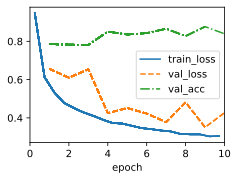

In [10]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(train=True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [13]:
model.net[1].gamma.reshape(-1)

tensor([1.5873, 1.6004, 2.2562, 2.1231, 1.4516, 1.7504],
       grad_fn=<ReshapeAliasBackward0>)

In [15]:
model.net[1].beta.reshape(-1)

tensor([ 0.5664,  1.1851, -0.8355, -1.5280,  1.5593,  0.7815],
       grad_fn=<ReshapeAliasBackward0>)

concise implementation :

In [17]:
nn.LazyBatchNorm1d??

In [7]:
class BNLeNet(d2l.Classifier):

  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.LazyBatchNorm1d(), nn.Sigmoid(),
        nn.LazyLinear(84), nn.LazyBatchNorm1d(), nn.Sigmoid(),
        nn.LazyLinear(num_classes)
    )

  def forward(self, X):
    return self.net(X)

took 2min 29 seconds to train

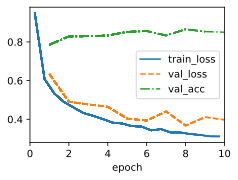

In [19]:
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(train=True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## Ex 8.5 :

### Q1:

in BNLeNet model setting bias = False in the fully connected layers

when using batch norm layer : due to the shift vector(beta) we don't need the bias term in the preceeding linear layer

In [8]:
class BNLeNet1(d2l.Classifier):

  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120, bias=False), nn.LazyBatchNorm1d(), nn.ReLU(),
        nn.LazyLinear(84, bias=False), nn.LazyBatchNorm1d(), nn.ReLU(),
        nn.LazyLinear(num_classes, bias=False)
    )

  def forward(self, X):
    return self.net(X)

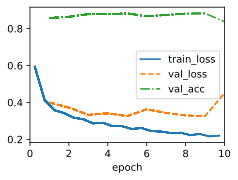

In [22]:
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet1(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(train=True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

### Q2:

In [ ]:
#@title DataSets
train_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [10]:
#@title Data Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           shuffle=True,
                                           batch_size=128)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                           shuffle=False,
                                           batch_size=128)

In [11]:
#@title Init CNN
def init_cnn(module):
  if type(module) == nn.Linear or type(module) == nn.Conv2d:
    nn.init.xavier_uniform_(module.weight)

In [12]:
#@title LeNet without Batch Norm
class LeNet(nn.Module):

  # without batch_norm
  def __init__(self, lr=0.01, num_classes=10):
    super().__init__()
    self.lr = lr
    self.num_classes = num_classes
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5), nn.ReLU(), 
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.ReLU(),
        nn.LazyLinear(84), nn.ReLU(),
        nn.LazyLinear(num_classes)
    )

  def forward(self, X):
    return self.net(X)

  def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
      self.net.apply(init)

In [13]:
#@title Trainer Class
class Trainer():

  def __init__(self, num_epochs):
    self.num_epochs = num_epochs

  def fit(self, model, loader):

    optimizer = torch.optim.SGD(model.parameters(), model.lr)
    criterion = nn.CrossEntropyLoss()
    
    # training loop : 
    for epoch in range(self.num_epochs):
      for i, (features, targets) in enumerate(loader):

        outputs = model(features)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [14]:
#@title Accuracy Function
def acc_model(model, loader):

  with torch.no_grad():
    n_samples = 0
    n_correct = 0
    for features, targets in loader:
      outputs = model(features)
      _, preds = torch.max(outputs, 1)
      n_samples += targets.shape[0]
      n_correct += (preds == targets).sum().item()

  acc = 100 * n_correct / n_samples
  return acc

first let's find the optimum learning rate for LeNet without batch norm:

took 19min 41seconds to train

lr = 0.1 is good

In [50]:
lr_list = [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]
acc_list = []

for lr in lr_list:
  model = LeNet(lr=lr)
  trainer = Trainer(num_epochs=10)
  model.apply_init([next(iter(train_loader))[0]], init_cnn)
  trainer.fit(model, train_loader)
  acc_list.append(acc_model(model, test_loader))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [15]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler

rcParams['figure.figsize'] = 16, 8
rcParams['lines.linewidth'] = 2.5
rcParams['axes.prop_cycle'] = cycler(color = ['#424242'])
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

In [55]:
acc_list

[82.11, 85.88, 86.95, 87.39, 87.99, 88.07, 88.69, 87.75, 10.0]

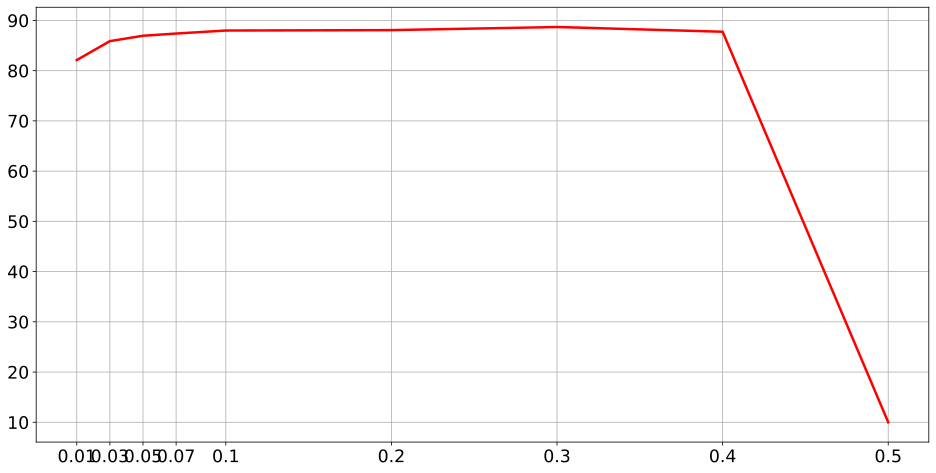

In [57]:
plt.plot(lr_list, acc_list, 'r-')
plt.xticks(lr_list, lr_list)
plt.grid();

let's try with batch norm: 

training time: 21min 10 seconds

lr = 0.5 is good

since we are using batch normalization it allows us to use much larger learning rates

for lr = 1.0 also the model is working fine

In [16]:
#@title LeNet with batch norm
class BNLeNet1(nn.Module):

  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.lr = lr
    self.num_classes = num_classes
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120, bias=False), nn.LazyBatchNorm1d(), nn.ReLU(),
        nn.LazyLinear(84, bias=False), nn.LazyBatchNorm1d(), nn.ReLU(),
        nn.LazyLinear(num_classes, bias=False)
    )

  def forward(self, X):
    return self.net(X)

  def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
      self.net.apply(init)

In [59]:
lr_list = [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]
acc_list = []

for lr in lr_list:
  model = BNLeNet1(lr=lr)
  trainer = Trainer(num_epochs=10)
  model.apply_init([next(iter(train_loader))[0]], init_cnn)
  trainer.fit(model, train_loader)
  acc_list.append(acc_model(model, test_loader))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [60]:
acc_list

[86.7, 88.06, 88.94, 88.67, 89.22, 89.71, 89.49, 89.2, 90.47]

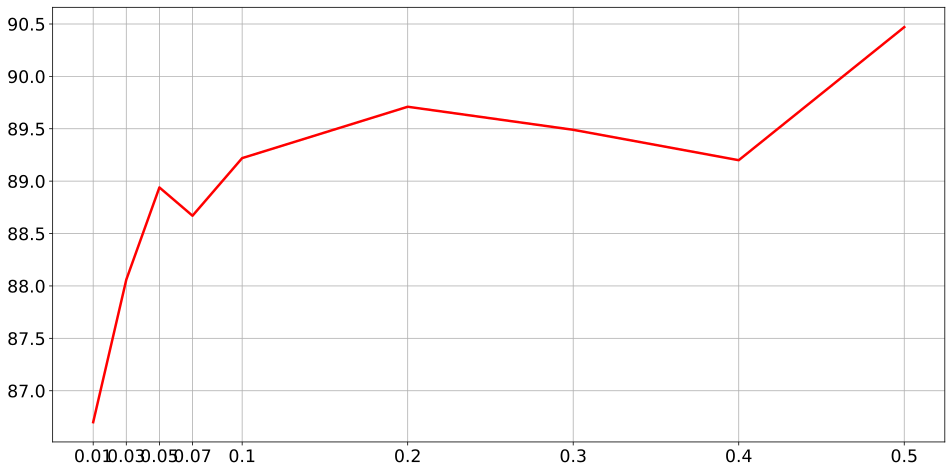

In [61]:
plt.plot(lr_list, acc_list, 'r-')
plt.xticks(lr_list, lr_list)
plt.grid();

In [65]:
model = BNLeNet1(lr=0.6)
trainer = Trainer(num_epochs=10)
model.apply_init([next(iter(train_loader))[0]], init_cnn)
trainer.fit(model, train_loader)
acc = acc_model(model, test_loader)
print(acc)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


89.36


In [66]:
lr_list = [0.7, 0.8, 0.9, 1.0]
acc_list = []

for lr in lr_list:
  model = BNLeNet1(lr=lr)
  trainer = Trainer(num_epochs=10)
  model.apply_init([next(iter(train_loader))[0]], init_cnn)
  trainer.fit(model, train_loader)
  acc_list.append(acc_model(model, test_loader))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


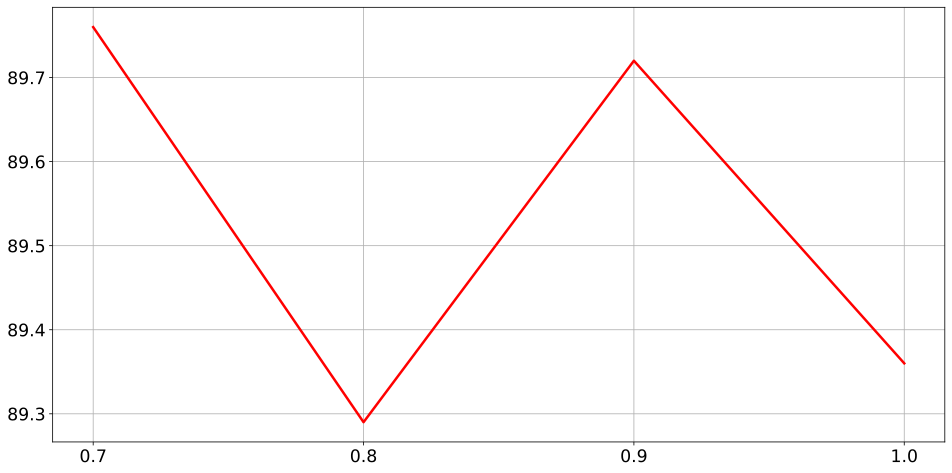

In [67]:
plt.plot(lr_list, acc_list, 'r-')
plt.xticks(lr_list, lr_list)
plt.grid();

### Q3:

using batch norm layer:

after conv layers only : acc = 89.31% (2min 20sec)

after fully connected layers only : acc = 89.01% (2min 11sec) with lr = 0.5

  acc = 89.47% (2min 15sec) with lr = 0.1

accuracy decreased a bit when we didn't use batch norm layers after every layer

In [17]:
#@title BNLeNet2
class BNLeNet2(nn.Module):

  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.lr = lr
    self.num_classes = num_classes
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120, bias=False), nn.LazyBatchNorm1d(), nn.ReLU(),
        nn.LazyLinear(84, bias=False),  nn.LazyBatchNorm1d(), nn.ReLU(),
        nn.LazyLinear(num_classes, bias=False)
    )

  def forward(self, X):
    return self.net(X)

  def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
      self.net.apply(init)

In [74]:
model = BNLeNet2(lr=0.1)
trainer = Trainer(num_epochs=10)
model.apply_init([next(iter(train_loader))[0]], init_cnn)
trainer.fit(model, train_loader)
acc = acc_model(model, test_loader)
print(acc)

89.47


In [84]:
model.net[8].state_dict()

OrderedDict([('weight',
              tensor([0.9766, 0.9978, 1.0322, 1.0186, 0.9809, 1.0304, 1.0147, 1.0637, 1.0035,
                      0.9842, 0.9932, 0.9758, 0.9587, 1.0102, 1.0544, 0.9968, 1.0261, 0.9826,
                      1.0007, 0.9882, 0.9628, 1.0361, 0.9892, 0.9539, 0.9801, 0.9847, 1.0474,
                      0.9608, 1.0035, 0.9578, 0.9526, 0.9557, 0.9930, 0.9635, 1.0366, 1.0120,
                      1.0102, 0.9979, 0.9641, 0.9437, 1.0168, 0.9841, 0.9556, 0.9986, 1.0027,
                      0.9734, 1.0092, 1.0306, 0.9984, 0.9820, 1.0378, 0.9809, 0.9737, 0.9819,
                      1.0482, 0.9899, 1.0613, 1.0287, 1.0612, 0.9689, 0.9358, 0.9907, 0.9732,
                      0.9824, 1.0116, 1.0203, 0.9847, 0.9657, 1.0251, 1.0431, 0.9963, 0.9835,
                      0.9731, 0.9911, 0.9867, 0.9710, 1.0196, 1.0535, 1.0066, 0.9802, 0.9531,
                      1.0469, 1.0244, 0.9877, 0.9962, 0.9989, 0.9862, 1.0058, 1.0357, 0.9423,
                      0.9902, 1.0040

### Q4:

when we just make the mean of the batch to be zero without changing the variance : acc = 86.96% (2min 29sec) lr = 0.1

unit variance but not changing the mean: 
acc = 85.81% (3min 46sec) lr = 0.1

accuracy decreased a bit in both the cases

In [18]:
def batch_norm_mod(X, gamma, beta, moving_var, eps, momentum):

  # just makes the mean of the batch zero

  if not torch.is_grad_enabled():
    X_hat = X / torch.sqrt(moving_var + eps)

  else:
    assert len(X.shape) in (2, 4)

    if len(X.shape) == 2:
      # we are using a fully connected layer
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)
    else:
      mean = X.mean(dim=(0, 2, 3), keepdim=True)
      var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)

    X_hat = X / torch.sqrt(var + eps)
    moving_var = (1.0 - momentum) * moving_var + momentum * var

  Y = gamma * X_hat + beta
  return Y, moving_var

In [19]:
class BatchNorm1(nn.Module):

  def __init__(self, num_features, num_dims):
    # num_features : number of outputs for a conv or fc layer
    # num_dims : 2 for fc layer and 4 for conv layer
    super().__init__()

    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)
    
    self.gamma = nn.Parameter(torch.ones(shape)) # scale parameter
    self.beta = nn.Parameter(torch.zeros(shape)) # shift parameter

    self.moving_var = torch.ones(shape)

  def forward(self, X):
    Y, self.moving_var = batch_norm_mod(X, self.gamma, self.beta, self.moving_var, eps=1e-5, momentum=0.1)
    return Y

In [20]:
#@title BNLeNet3 with custom batch_norm layer
class BNLeNet3(nn.Module):

  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.lr = lr
    self.num_classes = num_classes
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5), BatchNorm1(6, 4),nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), BatchNorm1(16, 4),nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), BatchNorm1(120, 2), nn.ReLU(),
        nn.LazyLinear(84),  BatchNorm1(84, 2), nn.ReLU(),
        nn.LazyLinear(num_classes)
    )

  def forward(self, X):
    return self.net(X)

  def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
      self.net.apply(init)

In [21]:
model = BNLeNet3(lr=0.1)
trainer = Trainer(num_epochs=10)
model.apply_init([next(iter(train_loader))[0]], init_cnn)
trainer.fit(model, train_loader)
acc = acc_model(model, test_loader)
print(acc)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


85.81


In [26]:
model.net[1].gamma.reshape(-1), model.net[1].beta.reshape(-1)

(tensor([0.7183, 0.7086, 0.9902, 2.0279, 0.6023, 1.0053],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-0.2237, -0.1515, -0.0920,  0.3600,  0.0393, -0.0834],
        grad_fn=<ReshapeAliasBackward0>))

### Q5:

need to make a custom layer with fixed beta and gamma

acc = 88.12% (4min) lr = 0.1

In [32]:
#@title BatchNorm2 fixes beta and gamma
class BatchNorm2(nn.Module):

  def __init__(self, num_features, num_dims):
    super().__init__()

    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)
    
    self.gamma = torch.rand(shape) # keeping beta and gamma to be fixed and not updating them during training
    self.beta = torch.rand(shape)

    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.zeros(shape)

  def forward(self, X):
    Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.1)
    return Y

In [30]:
#@title BNLeNet4
class BNLeNet4(nn.Module):

  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.num_classes = num_classes
    self.lr = lr
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5), BatchNorm2(6, 4), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), BatchNorm2(16, 4), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), BatchNorm2(120, 2), nn.ReLU(),
        nn.LazyLinear(84), BatchNorm2(84, 2), nn.ReLU(),
        nn.LazyLinear(num_classes)
    )

  def forward(self, X):
    return self.net(X)

  def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
      self.net.apply(init)

In [31]:
model = BNLeNet4(lr=0.1)
trainer = Trainer(num_epochs=10)
model.apply_init([next(iter(train_loader))[0]], init_cnn)
trainer.fit(model, train_loader)
acc = acc_model(model, test_loader)
print(acc)

88.12


### Q6:

using dropout instead of batch norm : acc = 80.64% (2min 56sec) lr = 0.1

In [34]:
#@title LeNet with dropout : DLeNet
class DLeNet(nn.Module):

  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.lr = lr
    self.num_classes = num_classes
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5), nn.ReLU(), nn.Dropout(p=0.5),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), nn.ReLU(), nn.Dropout(p=0.5),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.ReLU(), nn.Dropout(p=0.5),
        nn.LazyLinear(84), nn.ReLU(), nn.Dropout(p=0.5),
        nn.LazyLinear(num_classes)
    )

  def forward(self, X):
    return self.net(X)

  def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
      self.net.apply(init)

In [36]:
model = DLeNet(lr=0.1)
trainer = Trainer(num_epochs=10)
model.apply_init([next(iter(train_loader))[0]], init_cnn)
trainer.fit(model, train_loader)
acc = acc_model(model, test_loader)
print(acc)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


80.64
